In [1]:
!nvidia-smi

Sat Jun  6 10:17:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P2000        On   | 00000000:03:00.0 Off |                  N/A |
| 47%   36C    P5     5W /  75W |      1MiB /  5059MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import os
    import re
    import gc

    import numpy as np
    import pandas as pd
    import torch

    from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from pylab import rcParams
    import matplotlib.pyplot as plt
    from matplotlib import rc
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report
    from collections import defaultdict
    from textwrap import wrap

    from torch import nn, optim
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

---

## Data Loading and Exploration

---

In [4]:
DATA_PATH = './data'
RANDOM_SEED = 30

## COMMENTED CODE ##

'''# Read the original data and save it to a .csv file'''
SOURCE_COLUMNS = ['ID COMENTARI', 'TEXT COMENTARI', 'CONSTRUCTIU', 'TÒXIC', 'GRAU TOXICITAT', 
                  'SARCASME/IRONIA', 'BURLA/RIDICULITZACIÓ', 'INSULTS', 'ARGUMENTACIÓ/DIÀLEG', 
                  'LL. NEGATIU/TÒXIC', 'AGRESSIVITAT', 'INTOLERÀNCIA']
COLUMNS = ['source_id', 'text', 'constructive', 'toxic', 'toxicity_degree', 'sarcasm_irony', 'mockery_ridicule',
          'insults', 'argument_discussion', 'negative_toxic_lang', 'aggressiveness', 'intolerance', 'type']

dtypes = {col:(int if col == 'toxicity_degree' else str) for col in COLUMNS}

data = pd.DataFrame(columns=COLUMNS)
for file in os.listdir(DATA_PATH):
    if file.endswith('Gold Standard 27maig2020(1).xlsx'):
        comments_type = re.sub('\s.*', '', file)
        
        new_sheet = pd.read_excel(os.path.join(DATA_PATH, file), usecols=SOURCE_COLUMNS)
        new_sheet.columns = COLUMNS[:-1]
        new_sheet.index.name = 'id'
        new_sheet.dropna(subset=['text'], inplace=True)
        new_sheet['type'] = [comments_type] * new_sheet.shape[0]
        new_sheet['text'] = new_sheet.text.str.replace('\xa0', ' ').str.strip()
        
        if comments_type == 'ECONOMIA':
            new_sheet.source_id.fillna('76', inplace=True)
        elif comments_type == 'RELIGIÓN':
            new_sheet.source_id.fillna('54-bis', inplace=True)
        
        data = data.append(new_sheet, ignore_index=True)
        
data = data.astype(dtypes)

data.to_csv(os.path.join(DATA_PATH, 'gold_standard_27maig2020.csv'), index=False, sep='|')

In [5]:
# Read the already saved .csv file with all comment types
data = pd.read_csv(os.path.join(DATA_PATH, 'gold_standard_27maig2020.csv'), sep='|')
data.head()

,source_id,text,constructive,toxic,toxicity_degree,sarcasm_irony,mockery_ridicule,insults,argument_discussion,negative_toxic_lang,aggressiveness,intolerance,type
0,1,Ya lo es,SÍ,NO,1,NO,NO,NO,NO,NO,NO,NO,ECONOMIA
1,1-bis,Se ve que ya han refundado el capitalismo sobr...,SÍ,SÍ,2,SÍ,NO,NO,SÍ,NO,NO,NO,ECONOMIA
2,2,Los planes de pensiones no suponen un sistema ...,SÍ,NO,1,NO,NO,NO,SÍ,NO,NO,NO,ECONOMIA
3,3,No estoy hablando de que los futuros pensionis...,SÍ,NO,1,NO,NO,NO,SÍ,NO,NO,NO,ECONOMIA
4,3-bis,De ninguna forma es un sistema que funcione me...,SÍ,NO,1,NO,NO,NO,NO,NO,NO,NO,ECONOMIA


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   source_id            1263 non-null   object
 1   text                 1263 non-null   object
 2   constructive         1263 non-null   object
 3   toxic                1263 non-null   object
 4   toxicity_degree      1263 non-null   int64 
 5   sarcasm_irony        1263 non-null   object
 6   mockery_ridicule     1263 non-null   object
 7   insults              1263 non-null   object
 8   argument_discussion  1263 non-null   object
 9   negative_toxic_lang  1263 non-null   object
 10  aggressiveness       1263 non-null   object
 11  intolerance          1263 non-null   object
 12  type                 1263 non-null   object
dtypes: int64(1), object(12)
memory usage: 128.4+ KB


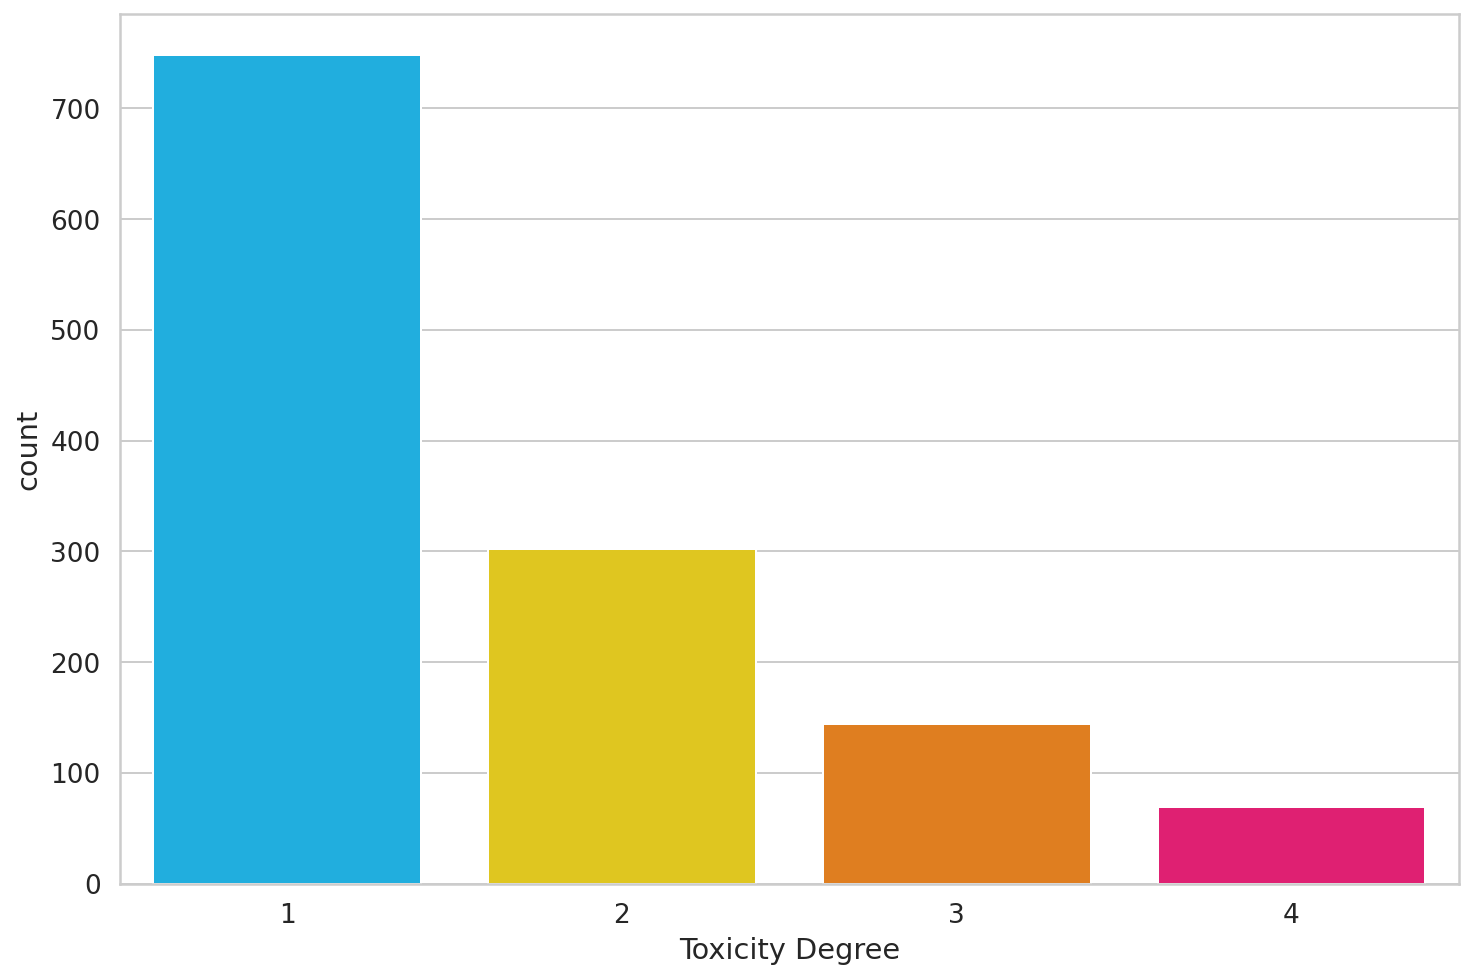

In [7]:
sns.countplot(data.toxicity_degree)
plt.xlabel('Toxicity Degree');

---

It can be seen that the classes are imbalanced. In order to account for this issue, we will try different ML techniques, as well as possibly varying the loss function accordingly.

---

In [8]:
# Shift the classes to start at 0
data.toxicity_degree = data.toxicity_degree - 1

In [9]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=list(zip(data.toxicity_degree, data.type)))
val, test = train_test_split(test, test_size=0.5, random_state=RANDOM_SEED, stratify=list(zip(test.toxicity_degree, test.type)))

In [10]:
train.shape, val.shape, test.shape

((1010, 13), (126, 13), (127, 13))

Text(0.5, 0, 'Test Toxicity Degree')

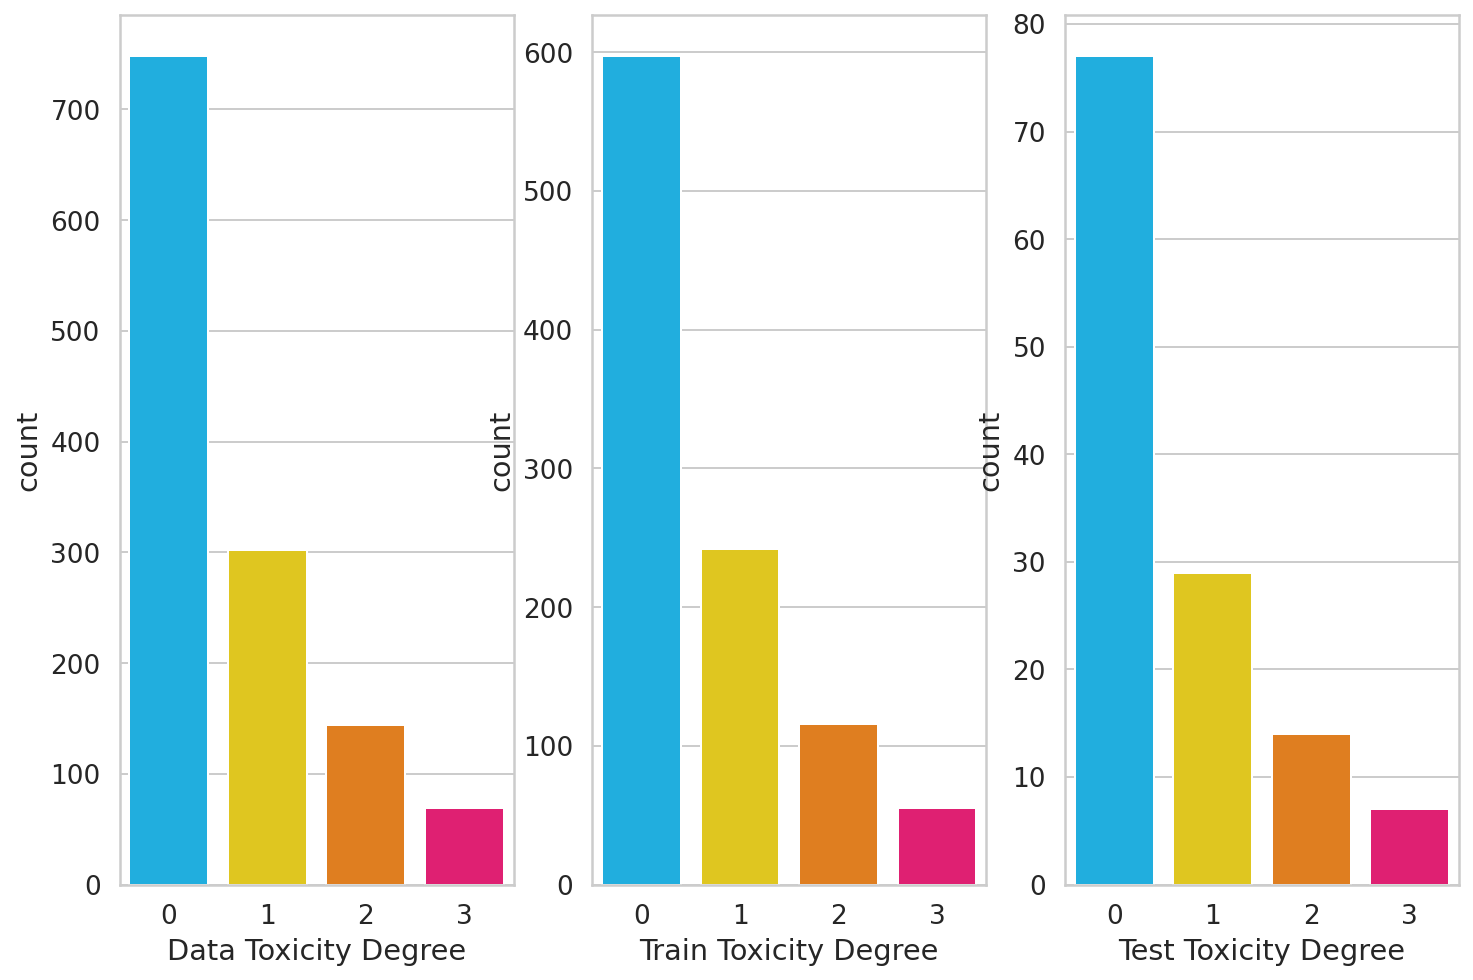

In [11]:
plt.figure()
ax = plt.subplot(131)
sns.countplot(data.toxicity_degree)
ax.set_xlabel('Data Toxicity Degree')
ax = plt.subplot(132)
sns.countplot(train.toxicity_degree)
ax.set_xlabel('Train Toxicity Degree')
ax = plt.subplot(133)
sns.countplot(test.toxicity_degree)
ax.set_xlabel('Test Toxicity Degree')

[Text(0, 0, 'INMIGRACIÓN'),
 Text(0, 0, 'RELIGIÓN'),
 Text(0, 0, 'POLÍTICA'),
 Text(0, 0, 'ECONOMIA')]

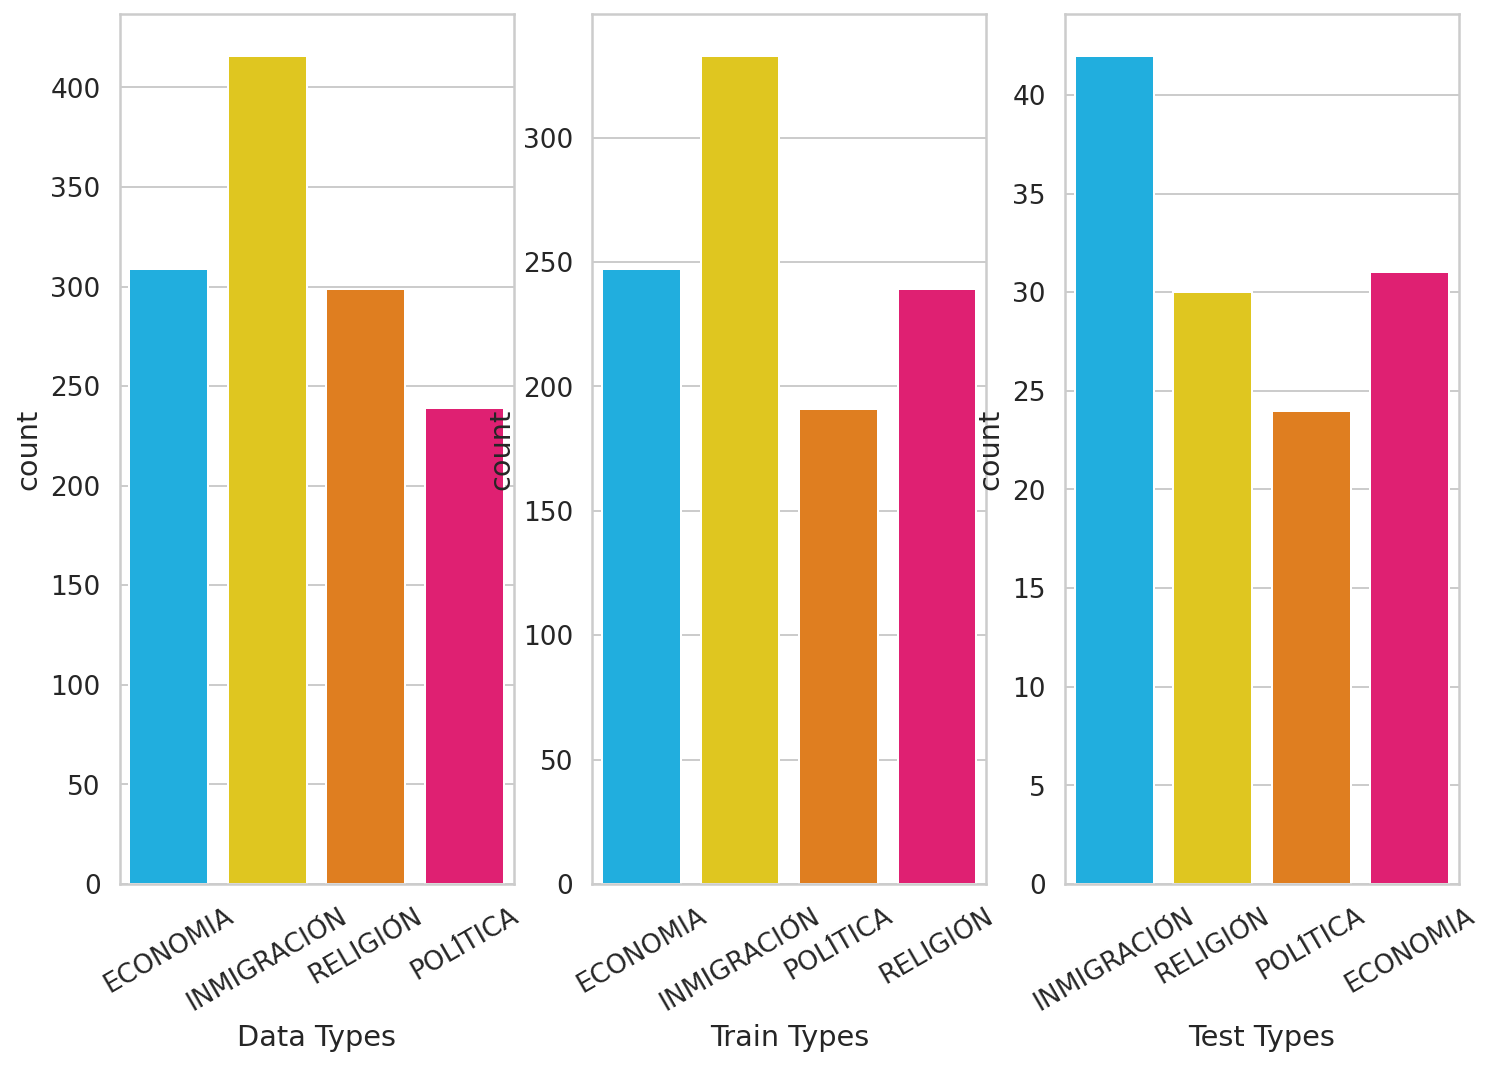

In [12]:
plt.figure()
ax = plt.subplot(131)
sns.countplot(data.type)
ax.set_xlabel('Data Types')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax = plt.subplot(132)
sns.countplot(train.type)
ax.set_xlabel('Train Types')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax = plt.subplot(133)
sns.countplot(test.type)
ax.set_xlabel('Test Types')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

---

# Pytorch models

---

---

## Data Preprocessing

---

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
LEARNING_RATE = 2e-5
EPOCHS = 10
BATCH_SIZE = 16

In [10]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
# Example of the tokenizer's output
sample_txt = 'Menudo idiota es este tío, flipante!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: Menudo idiota es este tío, flipante!
Tokens: ['menudo', 'idi', '##ota', 'es', 'este', 'tio', ',', 'flip', '##ante', '!']
Token IDs: [37878, 19338, 14706, 10153, 10494, 34451, 117, 78048, 15514, 106]


In [12]:
# Let's see the special tokens that the tokenizer requires to add to the sentence
print(tokenizer.cls_token, '-', tokenizer.cls_token_id)
print(tokenizer.pad_token, '-', tokenizer.pad_token_id)
print(tokenizer.sep_token, '-', tokenizer.sep_token_id)
print(tokenizer.unk_token, '-', tokenizer.unk_token_id)
print(tokenizer.mask_token, '-', tokenizer.mask_token_id)

[CLS] - 101
[PAD] - 0
[SEP] - 102
[UNK] - 100
[MASK] - 103


In [13]:
encoding = tokenizer.encode_plus(
    sample_txt, 
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
encoding['input_ids'].flatten()

tensor([  101, 37878, 19338, 14706, 10153, 10494, 34451,   117, 78048, 15514,
          106,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [15]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'menudo', 'idi', '##ota', 'es', 'este', 'tio', ',', 'flip', '##ante', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [16]:
# The maximum number of tokens admitted by BERT is 512
token_lens = data.text.apply(lambda x: len(tokenizer.encode(x, max_length=512))).to_numpy()

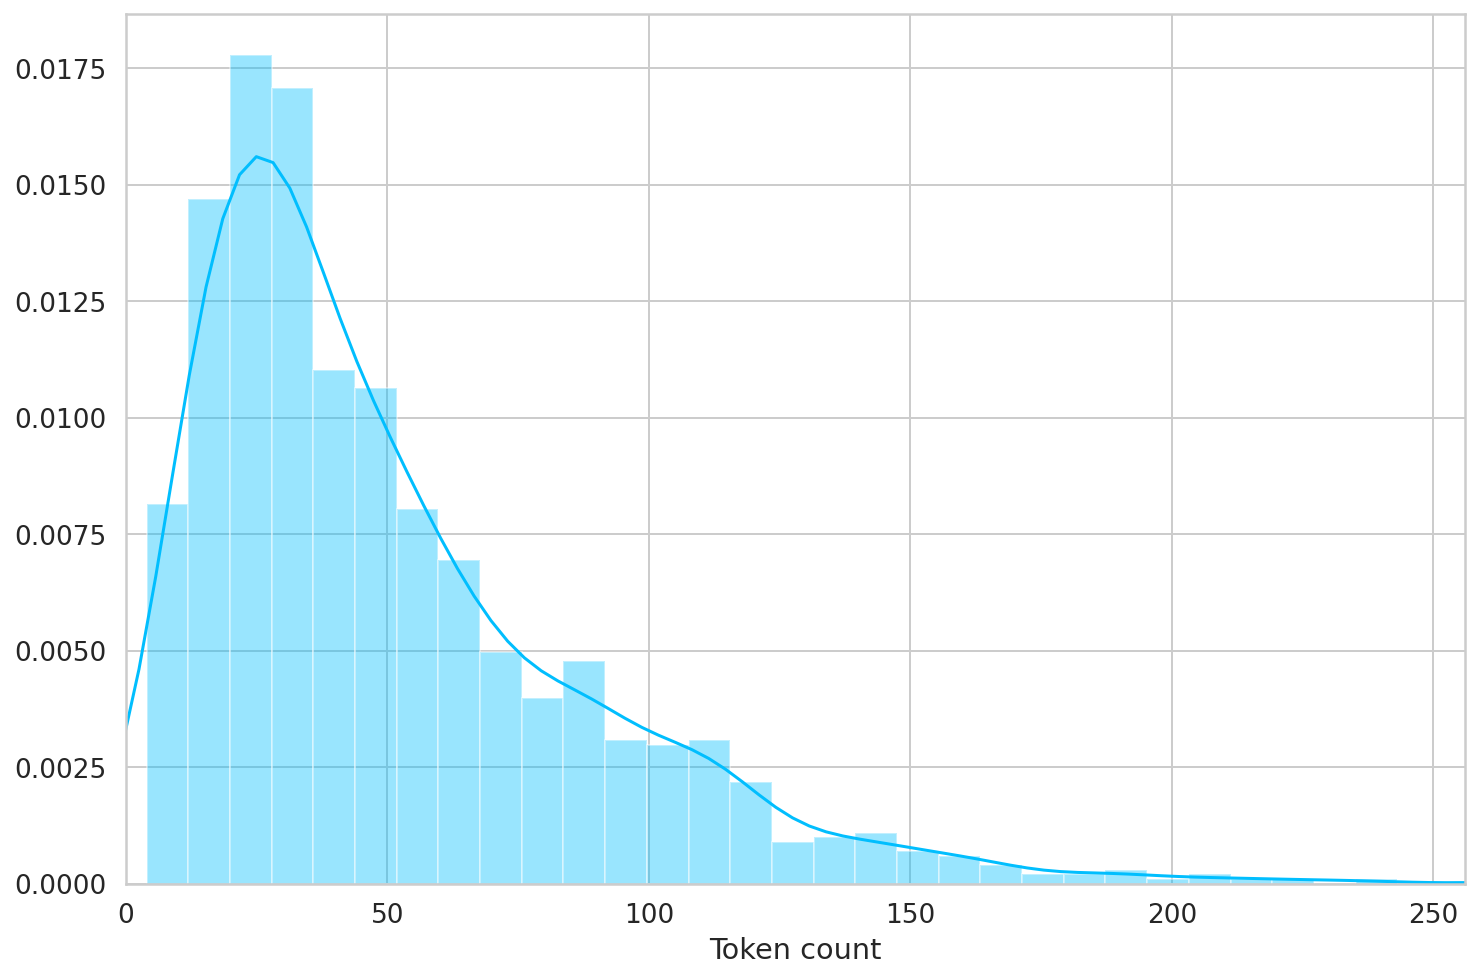

In [17]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

---

Given the distribution of the token lens in the text, most of the texts will have a length shorter that 200 so we'll take that value as the starting point for the max_length parameter.

---

In [18]:
MAX_LEN = 150

In [19]:
class HateSpeechDataset(Dataset):
    def __init__(self, comments, targets, tokenizer, max_len):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.comments)
  
    def __getitem__(self, item):
        comment = self.comments[item]
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [22]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    dataset = HateSpeechDataset(
        comments=data.text.to_numpy(),
        targets=data.toxicity_degree.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4
    )

In [23]:
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [24]:
s_data = next(iter(train_data_loader))
s_data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(s_data['input_ids'].shape)
print(s_data['attention_mask'].shape)
print(s_data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [26]:
model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [27]:
last_hidden_state = model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
)[0]

In [28]:
print('Last Hidden State Shape:', last_hidden_state.shape)
print('Number of hidden units:', model.config.hidden_size)
print('Number of tokens:', len(encoding['input_ids'].flatten()))

Last Hidden State Shape: torch.Size([1, 32, 768])
Number of hidden units: 768
Number of tokens: 32


In [29]:
class HateSpeechClassifier(nn.Module):

    def __init__(self, n_classes):
        super(HateSpeechClassifier, self).__init__()
        self.model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.model.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        last_hidden_state = self.model(input_ids=input_ids,attention_mask=attention_mask)[0]
        output = self.drop(last_hidden_state[:, 0, :])
        return self.out(output)

In [30]:
model = HateSpeechClassifier(data.toxicity_degree.nunique())
model = model.to(device)  # It supposes a process of 1571MiB to the GPU

In [31]:
# Training the model
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)  # Still 1571MiB of GPU usage

In [32]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device, dtype = torch.long)
        attention_mask = d["attention_mask"].to(device, dtype = torch.long)
        targets = d["targets"].to(device, dtype = torch.long)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        del input_ids, attention_mask, targets, outputs, preds, loss
        torch.cuda.empty_cache()
        gc.collect()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device, dtype = torch.long)
            attention_mask = d["attention_mask"].to(device, dtype = torch.long)
            targets = d["targets"].to(device, dtype = torch.long)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            del input_ids, attention_mask, targets, outputs, preds, loss
            torch.cuda.empty_cache()
            gc.collect()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.2381491474807262 accuracy 0.5386138613861386
Val   loss 1.1817396581172943 accuracy 0.5873015873015872

Epoch 2/10
----------
Train loss 1.1970577500760555 accuracy 0.5683168316831684
Val   loss 1.1415657997131348 accuracy 0.5873015873015872

Epoch 3/10
----------
Train loss 1.1645113416016102 accuracy 0.5722772277227722
Val   loss 1.1160059571266174 accuracy 0.5873015873015872

Epoch 4/10
----------
Train loss 1.135590123012662 accuracy 0.5821782178217821
Val   loss 1.0999822542071342 accuracy 0.5873015873015872

Epoch 5/10
----------
Train loss 1.120336794294417 accuracy 0.5861386138613861
Val   loss 1.0896910205483437 accuracy 0.5873015873015872

Epoch 6/10
----------
Train loss 1.1218087617307901 accuracy 0.5871287128712871
Val   loss 1.083262488245964 accuracy 0.5873015873015872

Epoch 7/10
----------
Train loss 1.1093320110812783 accuracy 0.592079207920792
Val   loss 1.0792782455682755 accuracy 0.5873015873015872

Epoch 8/10
----------
Train los

---

# Tensorflow BERT model

---

In [13]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

In [14]:
# Configuration
EPOCHS = 10
BATCH_SIZE = 16
MAX_LEN = 150
MODEL = 'bert-base-multilingual-uncased'

AUTO = tf.data.experimental.AUTOTUNE

In [15]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        return_tensors='tf'
    )
    
    return np.array(enc_di['input_ids'])

In [16]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [18]:
x_train = regular_encode(train.text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(val.text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.text.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxicity_degree.values
y_valid = val.toxicity_degree.values

In [19]:
x_test.shape

(127, 150)

In [20]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [21]:
strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [22]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 150)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 150, 768), (None, 167356416 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 167,357,185
Trainable params: 167,357,185
Non-trainable params: 0
_________________________________________________________________
CPU times: user 3.66 s, sys: 512 ms, total: 4.17 s
Wall time: 4.88 s


In [23]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Train for 63 steps, validate for 8 steps
Epoch 1/10
 1/63 [..............................] - ETA: 21:26

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[16,12,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/tf_bert_model/bert/encoder/layer_._9/attention/self/Softmax (defined at /home/alejandro/.local/lib/python3.6/site-packages/transformers/modeling_tf_bert.py:252) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Reshape_819/_532]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[16,12,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/tf_bert_model/bert/encoder/layer_._9/attention/self/Softmax (defined at /home/alejandro/.local/lib/python3.6/site-packages/transformers/modeling_tf_bert.py:252) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_33234]

Errors may have originated from an input operation.
Input Source operations connected to node model/tf_bert_model/bert/encoder/layer_._9/attention/self/Softmax:
 model/tf_bert_model/bert/encoder/layer_._9/attention/self/add (defined at /home/alejandro/.local/lib/python3.6/site-packages/transformers/modeling_tf_bert.py:249)

Input Source operations connected to node model/tf_bert_model/bert/encoder/layer_._9/attention/self/Softmax:
 model/tf_bert_model/bert/encoder/layer_._9/attention/self/add (defined at /home/alejandro/.local/lib/python3.6/site-packages/transformers/modeling_tf_bert.py:249)

Function call stack:
distributed_function -> distributed_function


---

# Other ML models

---

In [24]:
# Let's try with a Random Forest Classifier using tf-idf
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [83]:
bow = TfidfVectorizer()
trn_bow_feats = bow.fit_transform(train.text.values).todense()

pca = PCA(n_components=0.5, svd_solver='full')
trn_bow_feats = pca.fit_transform(trn_bow_feats)

val_bow_feats = bow.transform(val.text.values).todense()
val_bow_feats = pca.transform(val_bow_feats)

In [84]:
trn_bow_feats.shape

(1010, 248)

In [85]:
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=int(np.sqrt(trn_bow_feats.shape[1])), 
                             bootstrap=True)
rfc.fit(trn_bow_feats, train.toxicity_degree.values)
y_pred = rfc.predict(val_bow_feats)
print('The validation accuracy is:', accuracy_score(val.toxicity_degree.values, y_pred))

The validation accuracy is: 0.5873015873015873


In [86]:
_, c = np.unique(val.toxicity_degree, return_counts=True)
c/val.shape[0]

array([0.58730159, 0.24603175, 0.11111111, 0.05555556])

In [87]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [58]:
manual_cols = ['constructive', 'toxic', 'sarcasm_irony', 'mockery_ridicule', 'insults', 'argument_discussion', \
       'negative_toxic_lang', 'aggressiveness', 'intolerance']

def mapping(val):
    mapper = {'si': 1, 'sí': 1, 'no':0, 'd': 1}
    return mapper[val.lower()]

le_train = train.loc[:, manual_cols].applymap(mapping)
le_val = val.loc[:, manual_cols].applymap(mapping)
trn_feats = train.loc[:, manual_cols].values

rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=3, bootstrap=True)
rfc.fit(le_train.loc[:, manual_cols].values, train.toxicity_degree.values)
y_pred = rfc.predict(le_val.loc[:, manual_cols].values)
print('The validation accuracy is:', accuracy_score(val.toxicity_degree.values, y_pred))

The validation accuracy is: 0.7936507936507936


In [57]:
np.unique(data.loc[:, manual_cols].values, return_counts=True)

(array(['D', 'NO', 'SI', 'SÍ', 'Sí'], dtype=object),
 array([   7, 8455,    1, 2902,    2]))

In [56]:
le_val

,constructive,toxic,sarcasm_irony,mockery_ridicule,insults,argument_discussion,negative_toxic_lang,aggressiveness,intolerance
606,0,0,0,0,0,0,0,0,0
95,0,0,0,1,0,0,0,0,0
64,1,0,0,0,0,1,0,0,0
1140,0,1,0,1,1,0,1,0,0
867,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
178,1,0,0,0,0,1,0,0,0
707,0,1,0,1,0,0,0,0,1
862,0,0,0,0,0,0,0,0,0
200,1,0,0,0,0,1,0,0,0


In [73]:
val_bow_feats

array([[-0.15209551, -0.01694883, -0.01773872, ..., -0.01906638,
        -0.02128746,  0.0240005 ],
       [-0.06265337, -0.06202518,  0.02966013, ..., -0.2059776 ,
         0.08981793,  0.06476792],
       [ 0.02184226, -0.03001316, -0.0530668 , ..., -0.00183497,
        -0.00571042, -0.00636634],
       ...,
       [-0.13542823,  0.05144032, -0.00915976, ..., -0.06755226,
         0.05573426,  0.03738201],
       [ 0.02789053, -0.08792434,  0.08351954, ..., -0.03303893,
        -0.02645141, -0.0039536 ],
       [ 0.05035268,  0.02197492, -0.08366145, ...,  0.01097383,
         0.10505739,  0.06623847]])

In [93]:
train.shape[0]

1010

In [94]:
len(train)

1010

In [98]:
a = torch.Tensor([[1,2,3],[4,5,1]])

_, b = torch.max(a, dim=1)
b.tolist()

[2, 1]